# Домашнее задание. Сверточные нейронные сети (10 баллов)
В этом домашнем задании вы потренируетесь в построении полносвязных и сверточных нейронных сетей. Мы сравним качество нейросетей на датасете MNIST с рукописными цифрами. Наша цель --- построить нейронную сеть для решения задачи классификации цифр на 10 классов.

## Оценивание задания
Это задание будет проверяться в формате peer-review. Это означает, что вашу посылку на Stepik будут проверять 3 других учащихся, и медианное значение их оценок будет выставлено в качестве окончательного балла. Чтобы получить баллы, вам также нужно будет проверить трех других учеников. Это станет доступно после того, как вы сдадите задание сами.

## Оформление посылки
В качестве решения необходимо послать ноутбук в формате .ipynb. Пожалуйста, сделайте файл максимально читаемым. Если размер вашего файла превышает 5 Мб, приложите текстовый документ со ссылкой на файл в Google Drive (не забудьте обеспечить доступ на чтение). Пожалуйста, проследите, чтобы у файла было верное расширение: иначе у других участников могут возникнуть проблемы с прочтением.

## Рекомендации по решению
Подробные критерии проверки станут доступными во время проверки на Stepik. Пока мы предлагаем несколько правил, которые помогут вам набрать максимальное количество баллов.
* Сначала оформите ноутбук, а затем перезапустите среду выполнения и выполните ноутбук заново (Среда выполнения→перезапустить и выполнить всё). Так вы убедитесь, что итоговый код вашего ноутбука корректен.
* В ноутбуке есть два типа проверки: 2 `assert`'а и 4 ключевых вопроса. Корректное решение должно проходить все `assert`-ы. Также необходимо дать ответы на все вопросы из ноутбука.
* Чем более понятным и читаемым вы сделаете код, тем больше шансов, что проверяющий поставит вам за него высокий балл.

Желаем удачи!


In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

import torchvision.transforms as tfs

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

## Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [2]:
import os
from torchvision.datasets import MNIST

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataloader =  torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 160108564.82it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 44258565.52it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 146457961.43it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 11219392.68it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## Часть 1. Полносвязные нейронные сети (3 балла)
Сначала решим MNIST с помощью полносвязной нейронной сети.

### Задание. Простая полносвязная нейронная сеть (1 балл)

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте функцию потерь для обучения (кросс-энтропия).


In [4]:
import torch.nn as nn

In [9]:
activation = nn.ELU()

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 128),
    activation,
    nn.Linear(128, 128),
    activation,
    nn.Linear(128, 10)
)

In [10]:
criterion = nn.CrossEntropyLoss() #YOUR CODE. Select a loss function
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения (1 балл)

In [12]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                 model.train()
                 optimizer.zero_grad()
                 outp = model(x_batch)
            else:
                 model.eval()
                 outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = y_batch.size(0)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.9014833333333333
Loader: valid. Accuracy: 0.9402
Epoch: 2
Loader: train. Accuracy: 0.9552
Loader: valid. Accuracy: 0.9593
Epoch: 3
Loader: train. Accuracy: 0.9674
Loader: valid. Accuracy: 0.9681
Epoch: 4
Loader: train. Accuracy: 0.9732333333333333
Loader: valid. Accuracy: 0.9636
Epoch: 5
Loader: train. Accuracy: 0.9769166666666667
Loader: valid. Accuracy: 0.9713
Epoch: 6
Loader: train. Accuracy: 0.9803333333333333
Loader: valid. Accuracy: 0.9733
Epoch: 7
Loader: train. Accuracy: 0.9823166666666666
Loader: valid. Accuracy: 0.9752
Epoch: 8
Loader: train. Accuracy: 0.98455
Loader: valid. Accuracy: 0.9765
Epoch: 9
Loader: train. Accuracy: 0.9859666666666667
Loader: valid. Accuracy: 0.9746
Epoch: 10
Loader: train. Accuracy: 0.9867166666666667
Loader: valid. Accuracy: 0.9766


In [19]:
elu_accuracy = accuracy['valid']
elu_accuracy

[0.9402,
 0.9593,
 0.9681,
 0.9636,
 0.9713,
 0.9733,
 0.9752,
 0.9765,
 0.9746,
 0.9766]

In [20]:
assert elu_accuracy[-1] > 0.97, 'Модель недостаточно хорошая. Нужно искать ошибку!'

### Задание. Протестируйте разные функции активации (1 балл)
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

Вам необходимо попробовать следующие функции активации:
* тождественная функция активации $f(x) = x$ (класс Identical реализован за вас ниже)
* сигмоида;
* ReLU;
* Leaky ReLU;
* Tanh (гиперболический тангенс).


In [27]:
elu_accuracy = accuracy["valid"]

In [26]:
def test_activation_function(activation):
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 128),
        activation(),
        nn.Linear(128, 128),
        activation(),
        nn.Linear(128, 10)
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    max_epochs = 10
    accuracy = {"train": [], "valid": []}

    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)
                preds = outp.argmax(-1)
                correct = (preds == y_batch).sum()
                all = len(y_batch)
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy

In [28]:
class Identical(nn.Module):
    def forward(self, x):
        return x

In [32]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def test_activation_function(activation):
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 128),
        activation(),
        nn.Linear(128, 128),
        activation(),
        nn.Linear(128, 10)
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    max_epochs = 10
    accuracy = {"train": [], "valid": []}

    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)
                preds = outp.argmax(-1)
                correct = (preds == y_batch).sum()
                all = len(y_batch)
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy

class Identical(nn.Module):
    def forward(self, x):
        return x

def get_valid_accuracy(activation):
    accuracy = test_activation_function(activation)
    return accuracy["valid"]

plain_accuracy = get_valid_accuracy(Identical)
sigmoid_accuracy = get_valid_accuracy(nn.Sigmoid)
relu_accuracy = get_valid_accuracy(nn.ReLU)
leaky_relu_accuracy = get_valid_accuracy(nn.LeakyReLU)
tanh_accuracy = get_valid_accuracy(nn.Tanh)

Epoch: 1
Loader: train. Accuracy: 0.8720166666666667
Loader: valid. Accuracy: 0.8981
Epoch: 2
Loader: train. Accuracy: 0.90035
Loader: valid. Accuracy: 0.9114
Epoch: 3
Loader: train. Accuracy: 0.9051
Loader: valid. Accuracy: 0.9063
Epoch: 4
Loader: train. Accuracy: 0.9060333333333334
Loader: valid. Accuracy: 0.9059
Epoch: 5
Loader: train. Accuracy: 0.9081666666666667
Loader: valid. Accuracy: 0.9016
Epoch: 6
Loader: train. Accuracy: 0.9099333333333334
Loader: valid. Accuracy: 0.9144
Epoch: 7
Loader: train. Accuracy: 0.9100333333333334
Loader: valid. Accuracy: 0.9158
Epoch: 8
Loader: train. Accuracy: 0.9110833333333334
Loader: valid. Accuracy: 0.9184
Epoch: 9
Loader: train. Accuracy: 0.9132
Loader: valid. Accuracy: 0.9102
Epoch: 10
Loader: train. Accuracy: 0.9141333333333334
Loader: valid. Accuracy: 0.9119
Epoch: 1
Loader: train. Accuracy: 0.8536
Loader: valid. Accuracy: 0.9307
Epoch: 2
Loader: train. Accuracy: 0.9394
Loader: valid. Accuracy: 0.9502
Epoch: 3
Loader: train. Accuracy: 0.95

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

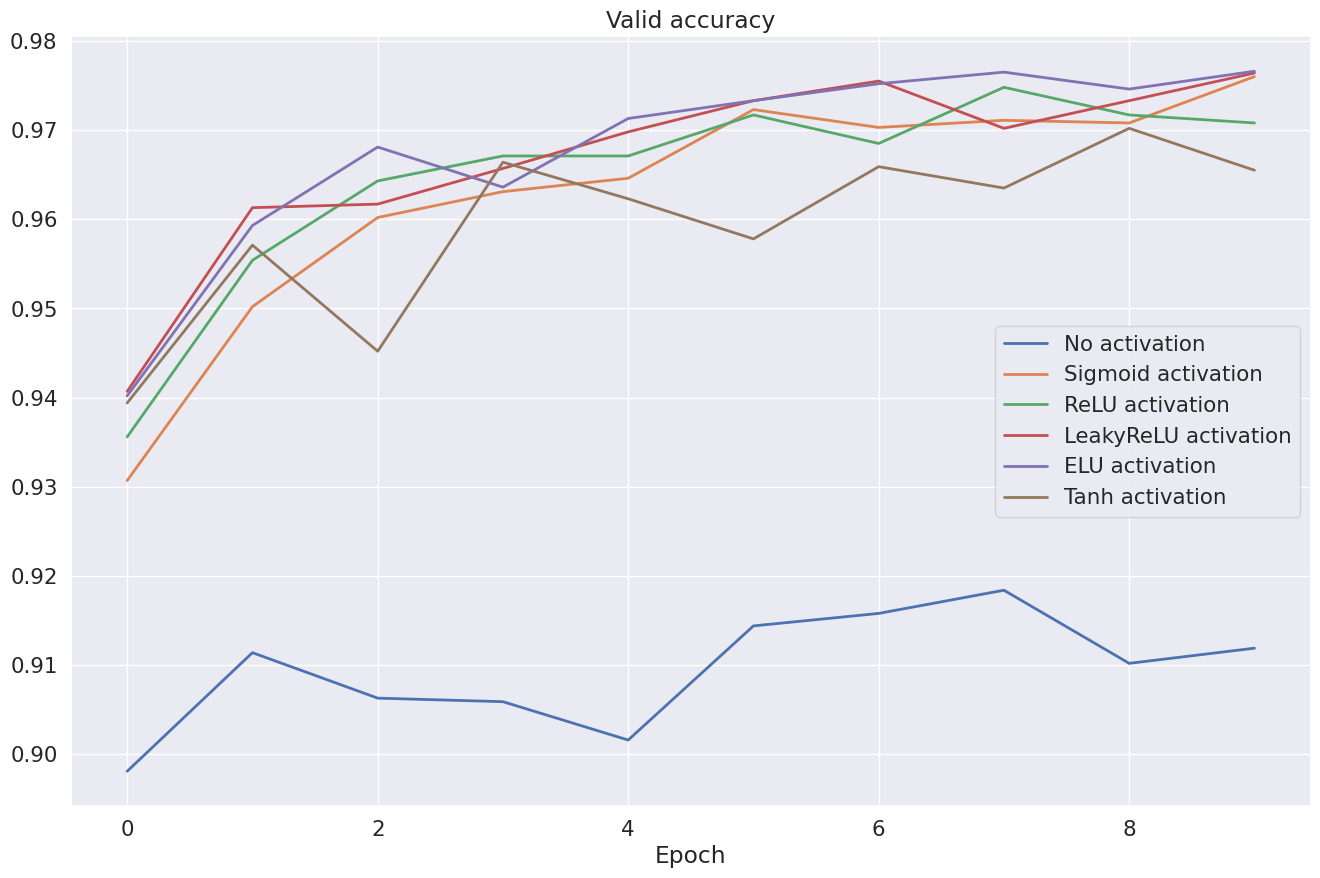

In [33]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), sigmoid_accuracy, label="Sigmoid activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), tanh_accuracy, label="Tanh activation", linewidth=2)

plt.legend()
plt.xlabel("Epoch")
plt.show()

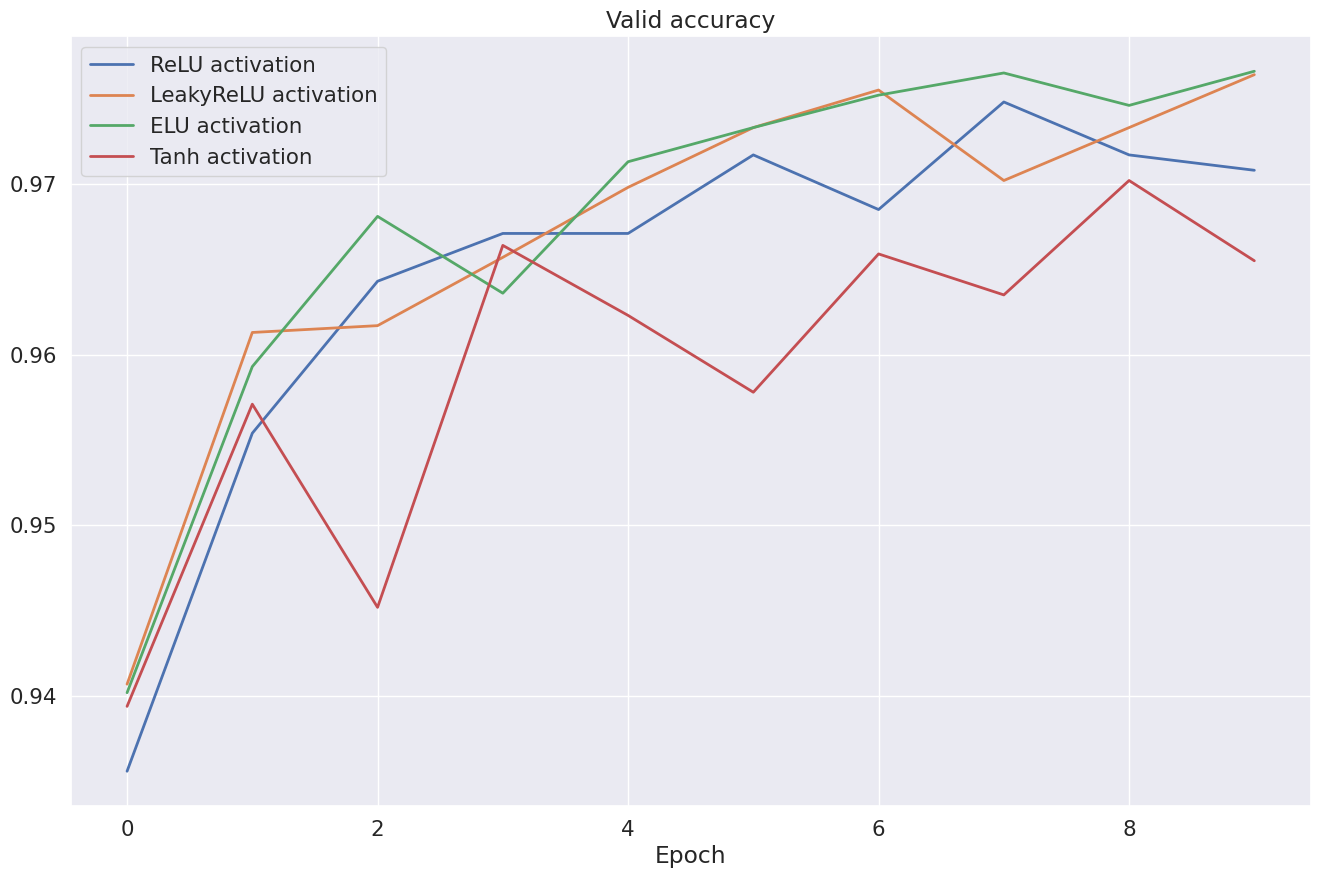

In [34]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), tanh_accuracy, label="Tanh activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 1.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ: ELU**

## Часть 2 Сверточные нейронные сети (7 баллов)

### Ядра (1 балл)
Сначала немного поработам с самим понятием ядра свёртки.

In [35]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2024-04-22 17:44:01--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 5.9.226.237
Connecting to img.the-village.kz (img.the-village.kz)|5.9.226.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   259KB/s    in 0.2s    

2024-04-22 17:44:03 (259 KB/s) - ‘sample_photo.jpg’ saved [49337/49337]



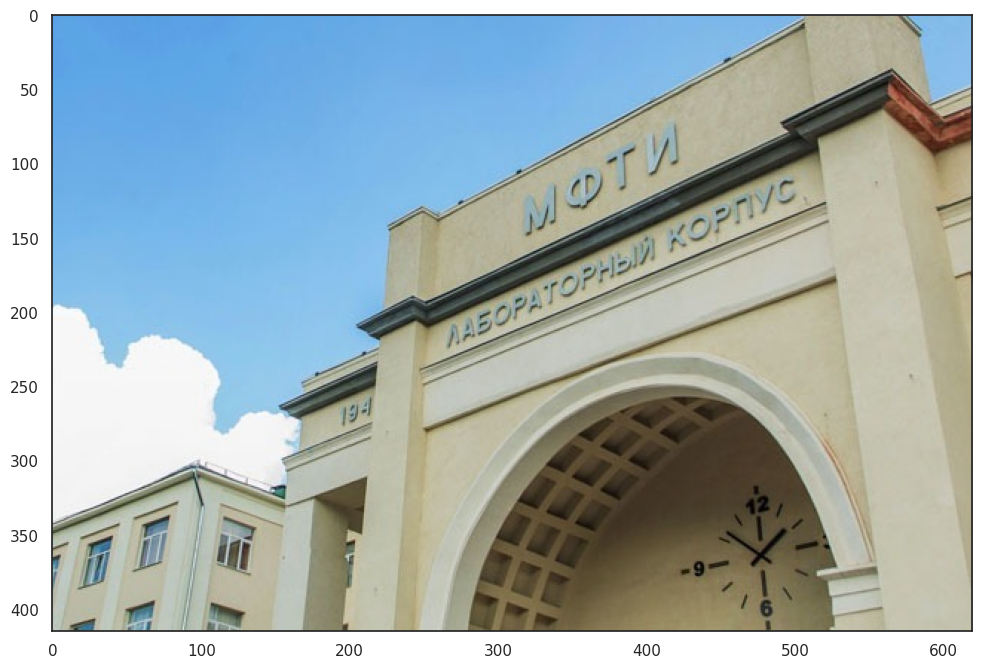

In [36]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото.
Например, попробуйте
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [53]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

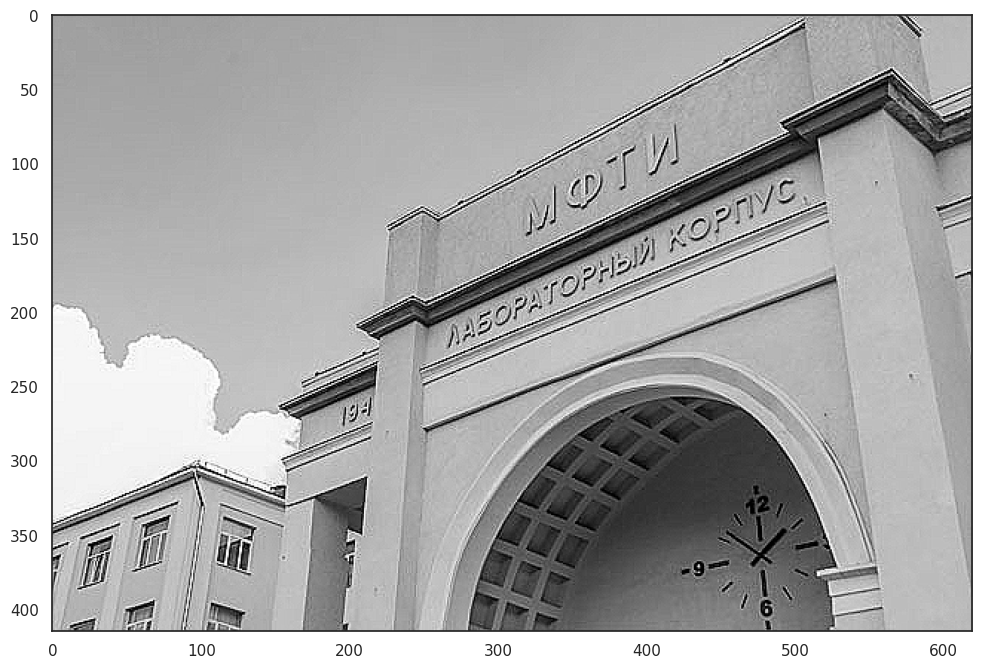

In [54]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 2.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие Е

2) Увеличение резкости Д

3) Тождественное преобразование А

4) Выделение вертикальных границ В

5) Выделение горизонтальных границ Б

6) Выделение границ Г

**Ответ: E, Д, А, В, Б, Г**

### Задание. Реализуйте LeNet (3 балла)

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [56]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [57]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN (3 балла)
Используйте код обучения, который вы написали для полносвязной нейронной сети. Обратите внимание, что сверточная нейронная сеть будет обучаться дольше. Нейронную сеть необходимо обучить до стабилизации графика функции потерь на валидационной выборке! Для этого может потребоваться большое количество эпох.

С какого-то момента качество на валидационной выборке начнет снова падать. В этот момент обучение можно прекращать.

Обратите внимание, что если модель не успела сойтись и вам нужно большее количество эпох, модель можно не переобучать с нуля, а запустить с уже частично обученными весами. Подумайте, как это сделать в коде.


Лучше запустить два эксперимента: на первом эксперименте оценить необходимое количество эпох, а на втором --- запустить обучение на таком количестве эпох и посчитать качество обученной модели на последней эпохе. Если бы в нашем распоряжении была тестовая выборка, можно было бы взять лучшую модель на валидации и вычислить ее качество на тесте.

In [60]:
max_epochs = 100
accuracy = {"train": [], "valid": []}
prev_valid_accuracy = 0

for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            optimizer.zero_grad()
            if k == "train":
                model.train()
                outp = model(x_batch.to(device))
            else:
                model.eval()
                outp = model(x_batch.to(device))
            preds = outp.argmax(dim=1)
            correct = (preds == y_batch.to(device)).sum().item()
            all = y_batch.size(0)
            epoch_correct += correct
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch.to(device))
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)
    # Проверка на early stopping
    if accuracy["valid"][-1] < prev_valid_accuracy:
        break
    prev_valid_accuracy = accuracy["valid"][-1]

Epoch: 1
Loader: train. Accuracy: 0.9121166666666667
Loader: valid. Accuracy: 0.9731
Epoch: 2
Loader: train. Accuracy: 0.9777166666666667
Loader: valid. Accuracy: 0.9851
Epoch: 3
Loader: train. Accuracy: 0.9842666666666666
Loader: valid. Accuracy: 0.9829


In [ ]:
lenet_accuracy = accuracy["valid"]

In [61]:
def get_valid_accuracy(activation):
    accuracy = test_activation_function(activation)
    return accuracy["valid"]

plain_accuracy = get_valid_accuracy(Identical)
sigmoid_accuracy = get_valid_accuracy(nn.Sigmoid)
relu_accuracy = get_valid_accuracy(nn.ReLU)
leaky_relu_accuracy = get_valid_accuracy(nn.LeakyReLU)
tanh_accuracy = get_valid_accuracy(nn.Tanh)

KeyboardInterrupt: 

Сравним с предыдущем пунктом

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), tanh_accuracy, label="Tanh activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 3**. Стабилизировалось ли качество вашей модели? Какая модель из всех обученных показала лучший результат?

**Ответ:**

**Вопрос 4**. Посчитайте accuracy после обучения с точностью до четырех знаков после запятой. Укажите качество с **последней** эпохи на валидационной выборке. **Обратите внимание, после перезапуска ноутбука перед отправкой на Stepik это число может измениться, так как есть небольшая случайная вариативность. Введите ответ, который дает итоговая версия вашего ноутбука.**

In [ ]:
best_accuracy = # YOUR CODE
assert best_accuracy > 0.987, 'Модель недостаточно хорошая. Нужно лучше!'